In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
from scipy.interpolate import UnivariateSpline

def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

In [2]:
import os
import sys
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [3]:
files = glob.glob('data/Spectra/SOPHIE/*.fits')

In [6]:
from astropy.io import fits

hdul = fits.open(files[0])
all_wav = hdul[1].data
all_flux = hdul[0].data / hdul[2].data # divided by blaze

In [7]:
plt.style.use('notebook')

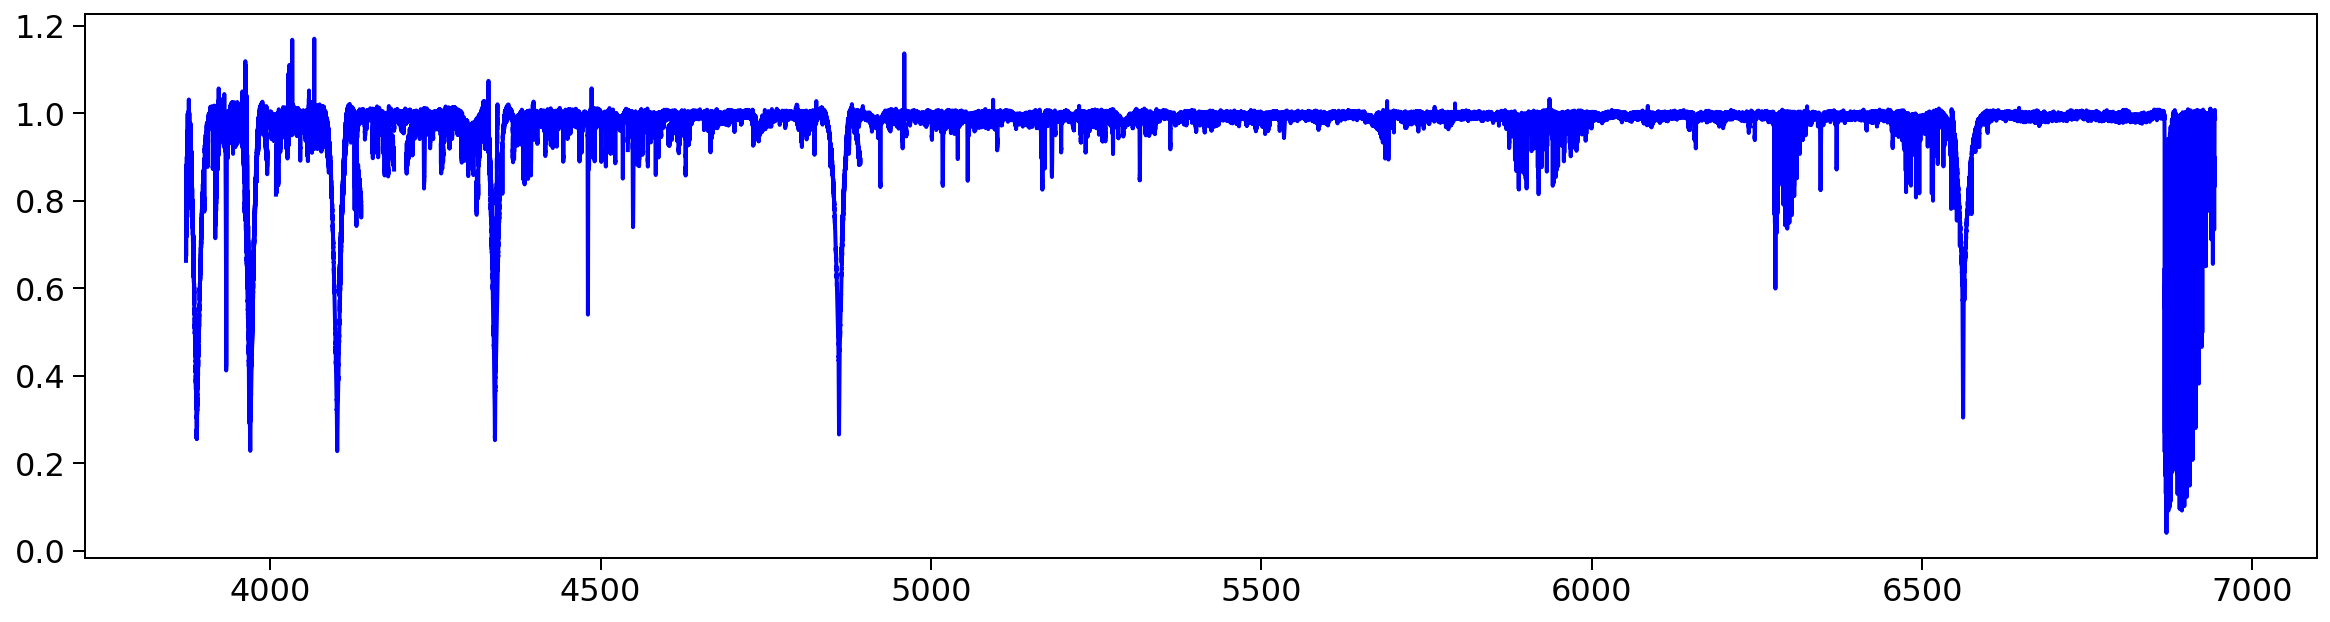

In [19]:
plt.figure(figsize=[20,5])

wavs, fluxs = [], []
for i in range(len(all_wav)):
    flux = all_flux[i]
    cont = fit_continuum(all_wav[i], flux, np.ones_like(all_wav[i], dtype=bool), order=3)
#     cont = flatten(all_wav[i], flux)
    plt.plot(all_wav[i], flux / cont, c='blue');
#     plt.plot(all_wav[i], cont, c='red');
    
#     plt.show()
    
#     plt.plot(all_wav[i], flux / cont)
    wavs.extend(all_wav[i])
    fluxs.extend(flux / cont)
    
wavs, fluxs = np.array(wavs), np.array(fluxs)

In [12]:
len(wavs), len(np.hstack(all_flux))

(159003, 159003)

In [13]:
np.savetxt('SOPHIE.txt', list(zip(wavs, fluxs, np.hstack(all_flux))))

(4500.0, 5000.0)

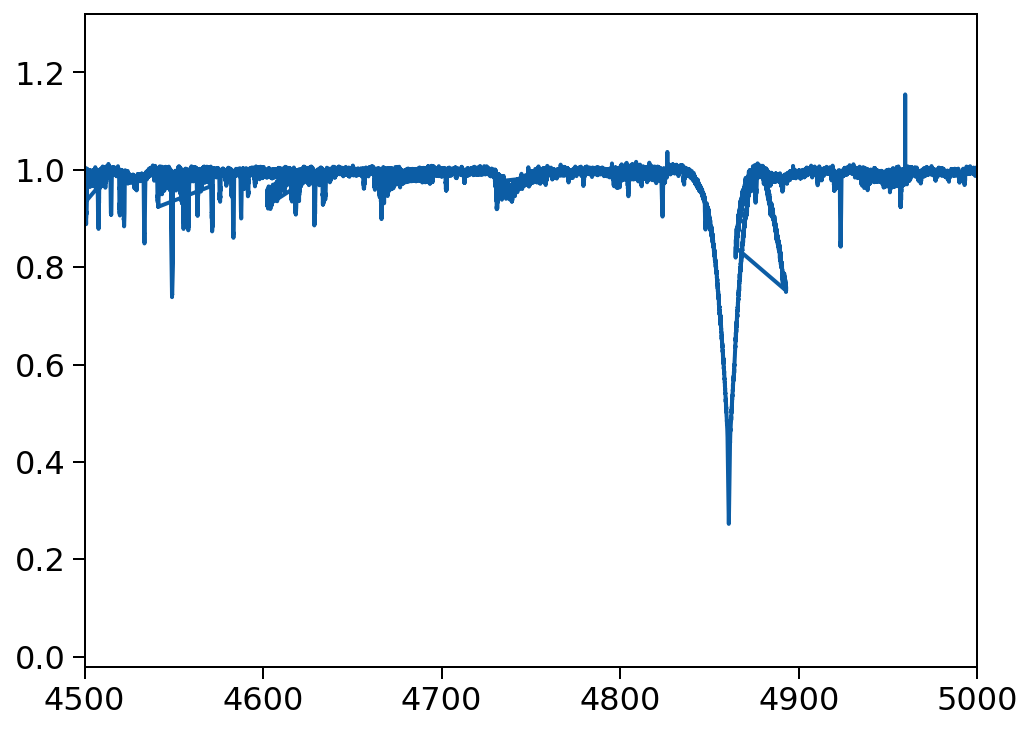

In [18]:
plt.plot(wavs, fluxs)
plt.xlim(4500, 5000)

(3970.0, 3985.0)

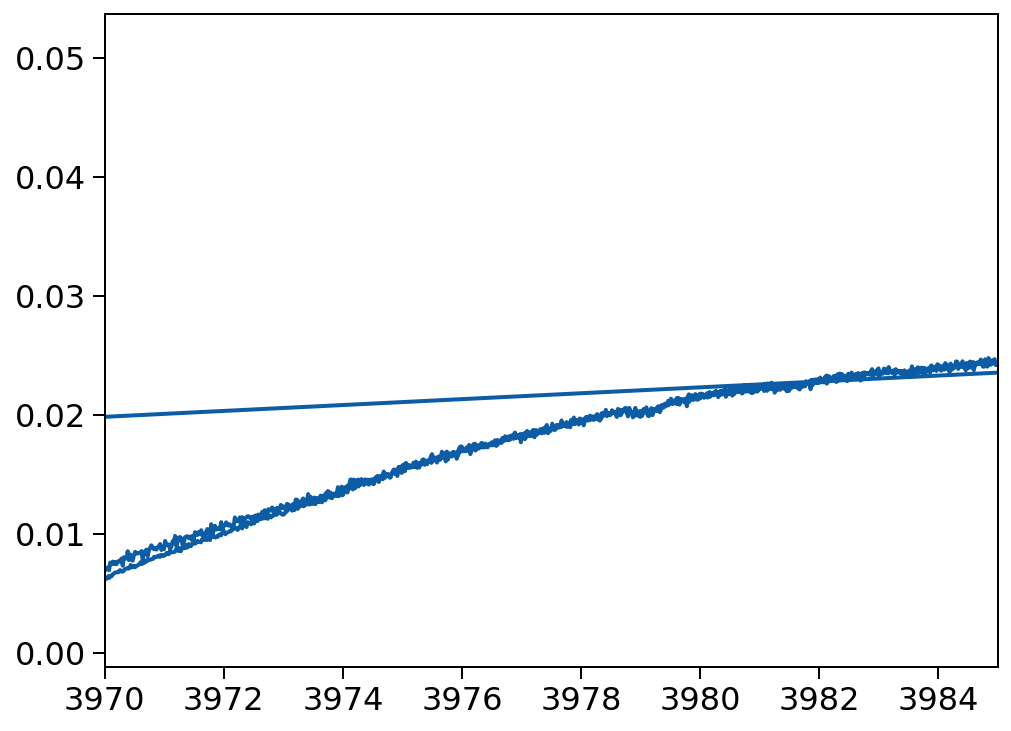

In [22]:
plt.plot(np.hstack(all_wav), np.hstack(all_flux))
plt.xlim(3970, 3985)

In [5]:
wav = np.arange(4000., 6800, 0.05)
m = np.zeros_like(wav, dtype=bool)
for i, file in enumerate(files):
    flux = pf.getdata(file)
    m = m | np.isnan(flux)
wav = np.arange(4000., 6800, 0.05)[~m]

ValueError: operands could not be broadcast together with shapes (56000,) (39,4077) 

In [7]:
plt.figure(figsize=[10,20])

all_spectra = []

for i, file in enumerate(files):
    flux = pf.getdata(file)
    flux = (flux[~m])
    
    flux /= fit_continuum(wav, flux, np.ones_like(wav, dtype=bool), order=6)
#     p = np.polyfit(wav, flux, deg=3)
#     model = np.polyval(p, wav)
#     flux /= model
    star_spectrum = ispec.create_spectrum_structure(wav / 10)
    star_spectrum['flux'] = flux
    all_spectra.append(star_spectrum)
#     plt.plot(wav, flux, lw=0.6)
#     print(len(wav))

<Figure size 720x1440 with 0 Axes>

In [9]:

import logging
LOG_LEVEL = "error"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

In [10]:
for spec in all_spectra[:]:
    snr = ispec.estimate_snr(spec['flux'], num_points=10)
    print(snr)

125.76428549658418
325.6048824763818
338.5698593760848
212.71425748939205
264.0303113255189
124.97687382428359
119.79098163302858
211.28310584865815
48.4076862462308
193.8051497927176
147.72050754721513
240.49863381283689
184.76385759027454
129.02951424574252
136.41718296914772
293.53515113281406
328.0916709942489


In [ ]:
# BJD-MID + 2400000
# OBS-MID

In [ ]:
spl(wav)\

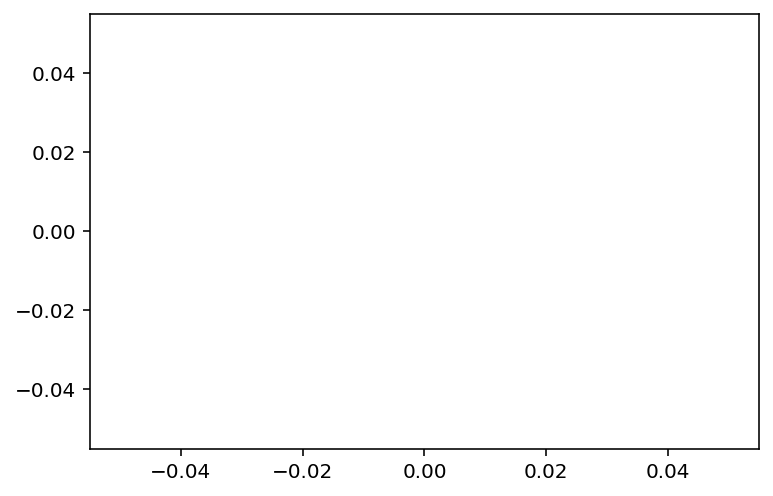

In [30]:
flat = flatten(wav, flux)
plt.plot(wav, flat)

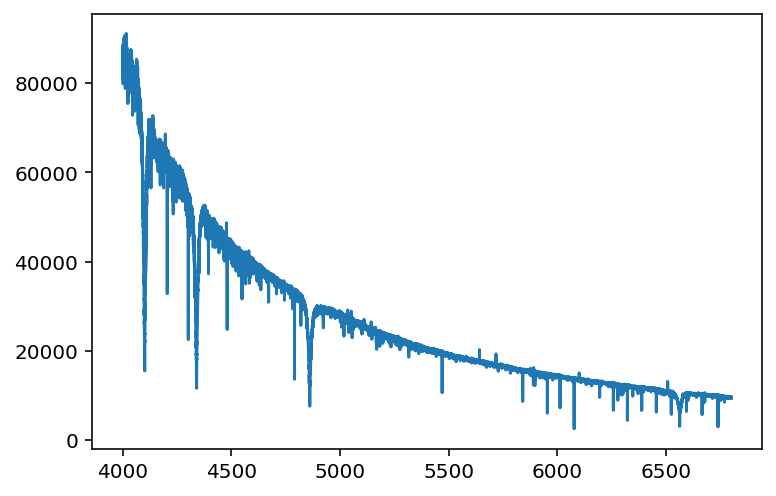

In [13]:
plt.plot(wav, spec_data)